# Neural Cleanse 实现代码【pytorch】

In [1]:
#!git clone https://github.com/tonggege001/MyNeuralCleanse.git

In [2]:
import os
os.chdir("./NeuralCleanse_Torch")

import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from data import get_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2024-10-09 11:14:44.599541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 11:14:44.609341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 11:14:44.621933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 11:14:44.625751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 11:14:44.635208: I tensorflow/core/platform/cpu_feature_guar

## 模型逆向
对每个标签依次优化mask，使得训练集图片加上mask之后能分到该标签

In [3]:

def train(model, target_label, train_loader, param):
    """对某一target_label的逆向trigger过程"""

    print("\nProcessing label: {}".format(target_label))

    # 设置初始的随机trigger，以及mask
    width, height = param["image_size"]
    trigger = torch.rand((3, width, height), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((width, height), requires_grad=True)  
    mask = mask.to(device).detach().requires_grad_(True)

    # 优化器的优化参数为trigger以及mask
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    criterion = CrossEntropyLoss()
    model.to(device)
    model.eval()

    # 训练参数
    Epochs = param["Epochs"]
    lamda = param["lamda"]

    # 记录mask的norm值，初始值为无穷大
    min_norm = np.inf 
    min_norm_count = 0

    # 遍历训练集数据，训练Epochs轮
    for epoch in range(Epochs):
        norm = 0.0
        for images, _ in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            images = images.to(device)

            # 把trigger和mask添加到图片上
            trojan_images = (1 - torch.unsqueeze(mask, dim=0)) * images + torch.unsqueeze(mask, dim=0) * trigger
            
            # 一般训练过程
            y_pred = model(trojan_images)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss.backward()
            optimizer.step()

            # 计算mask的norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
        print("norm: {}".format(norm))

        # early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 5:
            break

    return trigger.cpu(), mask.cpu()



def reverse_engineer():
    param = {
        "dataset": "cifar10",
        "Epochs": 20,  # 每个类别进行trigger逆向训练的轮数
        "batch_size": 64,
        "lamda": 0.01,
        "num_classes": 10,
        "image_size": (32, 32)
    }

    # 加载模型和数据集
    model = torch.load('model_cifar10.pkl', weights_only=False).to(device)
    _, _, x_test, y_test = get_data(param)
    x_test, y_test = torch.from_numpy(x_test)/255., torch.from_numpy(y_test)
    train_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=param["batch_size"], shuffle=False)
    
    # 开始逆向，依次遍历每个标签 
    norm_list = []
    for label in range(param["num_classes"]):
        # 对每个标签，逆向对应的trigger和mask
        trigger, mask = train(model, label, train_loader, param)
        norm_list.append(mask.sum().item())

        # 将逆向出的trigger和mask图像保存
        trigger = trigger.cpu().detach().numpy()
        trigger = np.transpose(trigger, (1,2,0))
        plt.axis("off")
        plt.imshow(trigger)
        plt.savefig('mask/trigger_{}.png'.format(label), bbox_inches='tight', pad_inches=0.0)

        mask = mask.cpu().detach().numpy()
        plt.axis("off")
        plt.imshow(mask)
        plt.savefig('mask/mask_{}.png'.format(label), bbox_inches='tight', pad_inches=0.0)

    print(norm_list)



Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 166.40it/s]


norm: 326.2520751953125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 241.49it/s]


norm: 160.39065551757812


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 236.39it/s]


norm: 87.38629150390625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 237.03it/s]


norm: 56.13905334472656


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 242.36it/s]


norm: 44.010433197021484


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 241.20it/s]


norm: 38.44121551513672


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 238.93it/s]


norm: 36.03856658935547


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 242.27it/s]


norm: 34.935638427734375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 237.94it/s]


norm: 33.94831085205078


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 232.46it/s]


norm: 33.12739181518555


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 167.45it/s]


norm: 32.55458450317383


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 183.06it/s]


norm: 32.180747985839844


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 165.46it/s]


norm: 31.82164764404297


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 209.54it/s]


norm: 31.68907928466797


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 179.47it/s]


norm: 31.59511947631836


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 214.99it/s]


norm: 31.553733825683594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 161.07it/s]


norm: 31.49306869506836


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 237.76it/s]


norm: 31.46240234375


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 238.41it/s]


norm: 31.337453842163086


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 235.04it/s]


norm: 31.243080139160156

Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 171.54it/s]


norm: 342.4000244140625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 166.62it/s]


norm: 172.37083435058594


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 183.32it/s]


norm: 93.13136291503906


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 243.74it/s]


norm: 60.44936752319336


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 237.99it/s]


norm: 48.56776428222656


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 233.98it/s]


norm: 43.636802673339844


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 217.25it/s]


norm: 41.581207275390625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.91it/s]


norm: 40.45667266845703


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 240.83it/s]


norm: 39.63177490234375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 223.72it/s]


norm: 38.90983200073242


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 235.72it/s]


norm: 38.248680114746094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 236.77it/s]


norm: 37.58835983276367


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 219.42it/s]


norm: 37.2663459777832


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 202.19it/s]


norm: 37.07246017456055


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 180.25it/s]


norm: 36.83578109741211


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 204.88it/s]


norm: 36.503482818603516


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 189.11it/s]


norm: 35.927093505859375


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 233.27it/s]


norm: 35.52445983886719


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 239.86it/s]


norm: 35.21759796142578


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 242.25it/s]


norm: 34.76393127441406

Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 243.58it/s]


norm: 293.01483154296875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 236.93it/s]


norm: 125.07695770263672


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 229.19it/s]


norm: 70.83192443847656


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 239.03it/s]


norm: 53.56209945678711


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 217.19it/s]


norm: 47.931007385253906


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 184.43it/s]


norm: 44.5235481262207


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 214.21it/s]


norm: 42.042179107666016


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 236.76it/s]


norm: 40.75973892211914


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 240.71it/s]


norm: 39.85127258300781


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 240.06it/s]


norm: 39.271995544433594


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 228.35it/s]


norm: 39.03618240356445


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 209.07it/s]


norm: 38.85588836669922


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 208.77it/s]


norm: 38.73902893066406


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 207.98it/s]


norm: 38.57101821899414


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 218.96it/s]


norm: 38.48524856567383


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 217.46it/s]


norm: 38.47750473022461


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 215.54it/s]


norm: 38.43600845336914


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 186.64it/s]


norm: 38.38996124267578


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 240.41it/s]


norm: 38.36800765991211


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 232.64it/s]


norm: 38.227481842041016

Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 233.35it/s]


norm: 205.72311401367188


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 198.62it/s]


norm: 89.48381042480469


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 181.24it/s]


norm: 62.80386734008789


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 202.86it/s]


norm: 54.359378814697266


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 237.19it/s]


norm: 49.64789581298828


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 235.59it/s]


norm: 47.608970642089844


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 226.61it/s]


norm: 46.806671142578125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 218.22it/s]


norm: 46.17887878417969


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 212.63it/s]


norm: 45.564476013183594


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 223.75it/s]


norm: 45.257568359375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 237.72it/s]


norm: 44.907386779785156


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 246.12it/s]


norm: 44.70494079589844


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 44.40489959716797


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 237.20it/s]


norm: 43.548423767089844


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 239.33it/s]


norm: 43.08463668823242


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 234.60it/s]


norm: 42.88501739501953


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 245.51it/s]


norm: 42.843814849853516


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 242.51it/s]


norm: 42.77484893798828


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 207.80it/s]


norm: 42.55313491821289


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 226.05it/s]


norm: 42.286590576171875

Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 225.29it/s]


norm: 308.27386474609375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 219.26it/s]


norm: 149.62582397460938


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 234.02it/s]


norm: 93.4591293334961


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 229.77it/s]


norm: 70.27206420898438


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 230.87it/s]


norm: 57.286888122558594


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 232.31it/s]


norm: 51.484859466552734


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 237.09it/s]


norm: 48.75375747680664


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 207.82it/s]


norm: 47.26630783081055


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 225.29it/s]


norm: 46.55143356323242


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 235.98it/s]


norm: 46.05957794189453


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 244.83it/s]


norm: 45.46746063232422


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 245.61it/s]


norm: 45.19218444824219


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 243.48it/s]


norm: 44.959083557128906


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 231.30it/s]


norm: 44.240150451660156


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 245.19it/s]


norm: 43.438804626464844


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 42.580718994140625


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 246.27it/s]


norm: 42.01651382446289


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 202.90it/s]


norm: 41.58911895751953


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 228.98it/s]


norm: 41.3300895690918


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 226.14it/s]


norm: 40.585426330566406

Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 247.01it/s]


norm: 339.04364013671875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 245.30it/s]


norm: 165.75070190429688


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.65it/s]


norm: 90.322265625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.75it/s]


norm: 59.824737548828125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 47.737274169921875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 235.06it/s]


norm: 42.0402717590332


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 220.53it/s]


norm: 38.81113815307617


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 238.17it/s]


norm: 36.465599060058594


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 240.71it/s]


norm: 35.11785125732422


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 228.49it/s]


norm: 34.39859390258789


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 233.59it/s]


norm: 33.931663513183594


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 240.80it/s]


norm: 33.36687469482422


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 239.52it/s]


norm: 33.0899658203125


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 225.59it/s]


norm: 32.93923568725586


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 226.31it/s]


norm: 32.79674530029297


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 225.62it/s]


norm: 32.69257736206055


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 242.81it/s]


norm: 32.75287628173828


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 32.35649871826172


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 244.91it/s]


norm: 32.15261459350586


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 243.02it/s]


norm: 31.986434936523438

Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 246.39it/s]


norm: 118.01219177246094


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 242.16it/s]


norm: 59.823814392089844


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.58it/s]


norm: 50.75337219238281


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 242.88it/s]


norm: 46.87799835205078


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 229.68it/s]


norm: 45.441646575927734


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 233.11it/s]


norm: 44.74761199951172


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 236.60it/s]


norm: 44.218040466308594


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 244.35it/s]


norm: 43.84327697753906


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 245.00it/s]


norm: 43.52954864501953


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 234.47it/s]


norm: 43.40455627441406


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 234.89it/s]


norm: 43.23492431640625


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 232.94it/s]


norm: 43.1033935546875


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 238.27it/s]


norm: 42.75468826293945


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 227.69it/s]


norm: 42.717933654785156


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 245.20it/s]


norm: 42.70918273925781


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 246.67it/s]


norm: 42.50361633300781


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 245.97it/s]


norm: 42.45197296142578


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 243.03it/s]


norm: 41.89120101928711


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 241.98it/s]


norm: 41.632164001464844


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 239.56it/s]


norm: 41.635643005371094

Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 230.16it/s]


norm: 333.4384765625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 232.08it/s]


norm: 167.19515991210938


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 222.18it/s]


norm: 92.9534683227539


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 224.38it/s]


norm: 63.51824188232422


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 224.83it/s]


norm: 51.75395584106445


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 223.26it/s]


norm: 45.65938186645508


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 218.34it/s]


norm: 42.70960998535156


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 235.05it/s]


norm: 41.032386779785156


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 235.79it/s]


norm: 39.74577331542969


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 228.89it/s]


norm: 38.219425201416016


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 231.89it/s]


norm: 37.66600036621094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 230.32it/s]


norm: 37.174957275390625


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 234.31it/s]


norm: 36.396392822265625


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 225.86it/s]


norm: 35.83726501464844


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 227.99it/s]


norm: 35.360939025878906


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 200.45it/s]


norm: 35.09272384643555


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 232.04it/s]


norm: 34.9286994934082


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 225.41it/s]


norm: 34.781524658203125


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 190.11it/s]


norm: 34.56601333618164


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 229.40it/s]


norm: 34.47952651977539

Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 225.19it/s]


norm: 322.38128662109375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 237.84it/s]


norm: 151.81057739257812


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 235.78it/s]


norm: 72.26593780517578


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 231.59it/s]


norm: 39.13979721069336


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 207.42it/s]


norm: 26.819477081298828


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 216.30it/s]


norm: 21.959396362304688


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 192.75it/s]


norm: 18.71038055419922


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 204.20it/s]


norm: 17.113121032714844


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 216.80it/s]


norm: 16.606964111328125


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 223.34it/s]


norm: 16.041419982910156


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 232.52it/s]


norm: 15.387661933898926


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 238.33it/s]


norm: 14.493423461914062


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 236.94it/s]


norm: 13.77817440032959


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 240.58it/s]


norm: 12.81148910522461


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 244.55it/s]


norm: 11.923846244812012


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 231.65it/s]


norm: 11.6998929977417


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 239.11it/s]


norm: 11.160826683044434


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 240.18it/s]


norm: 11.029766082763672


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 228.38it/s]


norm: 11.006817817687988


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 240.46it/s]


norm: 10.994203567504883

Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 229.52it/s]


norm: 260.072509765625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 227.82it/s]


norm: 104.45426177978516


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 234.73it/s]


norm: 60.51392364501953


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 217.91it/s]


norm: 45.78725814819336


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 227.78it/s]


norm: 41.63603973388672


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 244.97it/s]


norm: 39.739837646484375


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 238.01it/s]


norm: 38.767547607421875


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.93it/s]


norm: 38.14088821411133


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 240.74it/s]


norm: 37.51918029785156


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 244.51it/s]


norm: 36.836524963378906


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 241.18it/s]


norm: 36.53101348876953


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 236.33it/s]


norm: 36.31993865966797


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 239.54it/s]


norm: 36.107574462890625


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 245.50it/s]


norm: 35.82151794433594


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 246.17it/s]


norm: 35.58597946166992


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 236.99it/s]


norm: 35.126346588134766


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 34.879112243652344


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 241.30it/s]


norm: 34.85838317871094


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 242.08it/s]


norm: 34.79157257080078


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 224.22it/s]


norm: 34.727622985839844
[31.243080139160156, 34.76393127441406, 38.22748947143555, 42.28659439086914, 40.585426330566406, 31.986434936523438, 41.635643005371094, 34.479530334472656, 10.994203567504883, 34.72762680053711]


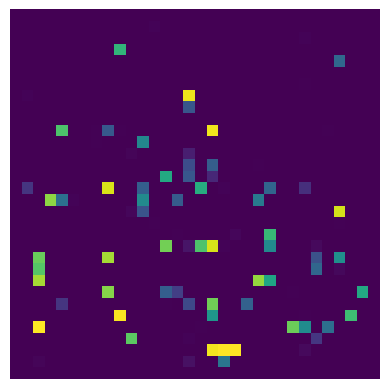

In [4]:
reverse_engineer()

## 显示逆向的trigger

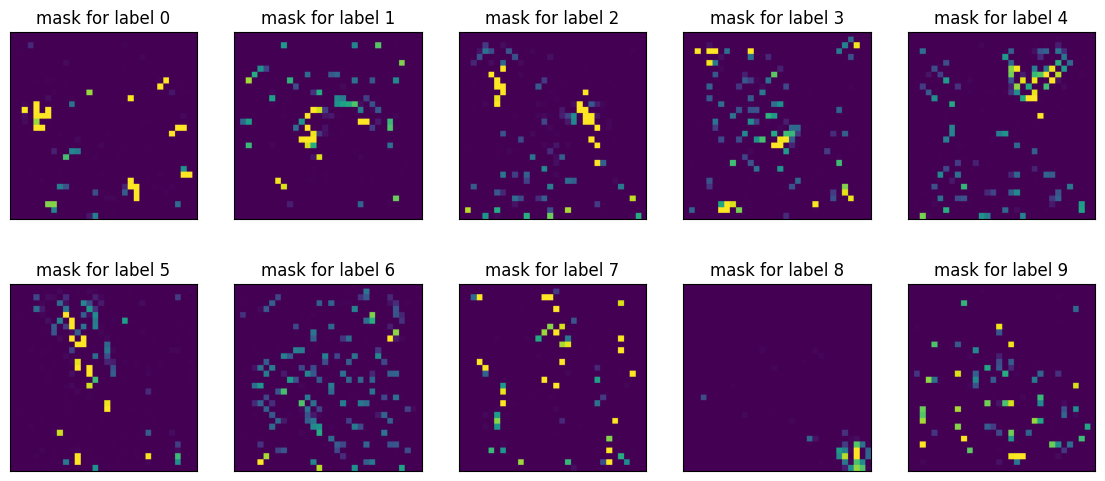

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))
N=2
M=5

#形成NxM大小的画布
for i in range(10):#有10张图片
    path='mask/mask_'+str(i)+'.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0
    plt.title('mask for label '+str(i))
    plt.imshow(img)

    plt.xticks([])
    plt.yticks([])
plt.show()

## 异常值检测方法MAD
找出trigger类别

In [6]:
from tensorflow.keras.utils import load_img,img_to_array

RESULT_DIR = 'mask'  # directory for storing results

# input size
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_COLOR)
NUM_CLASSES = 10  


def outlier_detection(l1_norm_list, idx_mapping):
    """MAD异常值检测"""

    # 计算MAD的median值
    consistency_constant = 1.4826  # if normal distribution
    median = np.median(l1_norm_list)
    mad = consistency_constant * np.median(np.abs(l1_norm_list - median))
    min_mad = np.abs(np.min(l1_norm_list) - median) / mad

    # anomaly index值大于2则认为模型存在后门
    print('median: %f, MAD: %f' % (median, mad))
    print('anomaly index: %f' % min_mad)

    # 找出norm大于2的mask标签
    flag_list = []
    for y_label in idx_mapping:
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        if np.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    if len(flag_list) > 0:
        flag_list = sorted(flag_list, key=lambda x: x[1])

    print('flagged label list: %s' %
          ', '.join(['%d: %2f' % (y_label, l_norm)
                     for y_label, l_norm in flag_list]))

    pass


def analyze_pattern_norm_dist():

    mask_flatten = []
    idx_mapping = {}

    # 读取每个标签的mask
    for y_label in range(NUM_CLASSES):
        mask_filename = "mask_%s.png" % y_label
        if os.path.isfile('%s/%s' % (RESULT_DIR, mask_filename)):
            img = load_img(
                '%s/%s' % (RESULT_DIR, mask_filename),
                color_mode='grayscale',
                target_size=INPUT_SHAPE)
            mask = img_to_array(img)
            mask /= 255
            mask = mask[:, :, 0]
            mask_flatten.append(mask.flatten())
            idx_mapping[y_label] = len(mask_flatten) - 1

    # 计算每个mask的L1 norm值
    l1_norm_list = [np.sum(np.abs(m)) for m in mask_flatten]
    print('%d labels found' % len(l1_norm_list))
    print("L1 Norm List:",l1_norm_list)

    # 对L1 norm值进行异常值检测
    outlier_detection(l1_norm_list, idx_mapping)

    pass



In [7]:
analyze_pattern_norm_dist()

10 labels found
L1 Norm List: [142.8902, 144.40001, 148.25883, 150.52942, 148.83139, 143.49805, 150.35297, 144.74118, 128.13727, 144.55295]
median: 144.647064, MAD: 3.979771
anomaly index: 4.148429
flagged label list: 8: 128.137268
